### Fully Automated Cardiac Shape Modeling

End-to-End automation of the Cardiac Atlas Project, from SSFP MRI to CIM Mesh. 

Steps:
1. View selection
2. Short axis slice selection
3. End-diastole and end-systole selection
     - Export Slice Info File
4. Landmark localization
5. Segmentation
6. Guide point extraction
     - Export guide point file
7. Python CIM GP fitting

In [1]:
# view selection
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
import cv2
import tensorflow as tf
import torch
import nnunet # directly imports local nnunet installation
from nnunet.inference.predict import predict_from_folder
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print('Python: {}'.format(sys.version))
print('Pydicom: {}'.format(pydicom.__version__))
print('TensorFlow: {}'.format(tf.__version__))
print('Torch: {}'.format(torch.__version__))



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Python: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Pydicom: 2.3.0
TensorFlow: 2.6.2
Torch: 1.10.2


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [3]:
# Only use CPU for right now - Set CPU as only available physical device
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

### Step 1: View Selection

The automated view selection is designed to automatically identify and select MRI views that are relavent to cardiac modeling. The analysis is designed to be run over a directory containing one or multiple patient subdirectories. The code runs the analysis iteratively over each subdirectory.

The suggested directory structures for each approach are shown below:

Run the analysis over each patient in a directory individually (i.e., analysis for patient 1, then analysis for patient 2.)

```bash
├── DATA
    ├── Patient1
    │   ├── 1.dcm
    │   ├── 2.dcm 
    │   ├── 3.dcm          
    │   └── ...   
    └── Patient2
        ├── 1.dcm
        ├── 2.dcm 
        ├── 3.dcm          
        └── ...          
```

In [4]:
# import the view selection scripts
from viewselection import ViewSelection

# PARAMETERS for the analysis
patient = 'CHD6257105'
src = "../data/raw/DICOMS Longitudinal/" + patient          # PATH to the directory containing the desired DICOM files (str)
dst = "../data/processed/"                        # PATH to the output directory to save dicom files (only valid if save_dicoms = True) (str)

# view selection model
modelname = 'ResNet50'                            # The neural network to load and used (Options: VGG19, ResNet50, or Xception)
use_multiprocessing = False                       # Use multiprocessing to read header info (True or False)

# parameters for postprocessing/saving
csv_path = '../data/processed/{}/view_predictions.csv'.format(patient)   # PATH to save the generated csv file (only valide if create_csv = True) (str)
create_csv = True                                 # Save a .csv file with the series level view predictions (True or False)
save_files = True                                 # Save dicom files to new directory (dst) (True or False)
save_only_desired = False                          # Save only dicom files corresponding to desired views (True or False)
confidence_value = 0.5                            # Only save series if the confidence is > a certain value (set to 0 to save all desired series, regardless of confidence) (float 0-1.0)

if not os.path.exists(os.path.join(dst, patient)):
    os.mkdir(os.path.join(dst,patient))

In [15]:
# initialize the viewSelector class with appropriate settings
viewSelector = ViewSelection(
                            src,
                            dst,
                            modelname,
                            csv_path,
                            create_csv,
                            use_multiprocessing,
                            save_files,
                            save_only_desired,
                            confidence_value
                            )

In [16]:
# initiate the tensorflow model
viewSelector.load_tensorflow_model()

# make predictions for src directory
viewSelector.complete_view_prediction()

In [39]:
import ipywidgets as widgets

# the view predictions are saved to the specified csv_path file. We can load in this csv file and 
# see what views were predicted for each series in the raw MRI dump. 
views = pd.read_csv(csv_path)
selected = views[views['Confidence'] > confidence_value] # select only
selected = selected[selected['Predicted View'].isin(['4CH', '3CH', 'SA', 'LVOT', 'RVOT', '2CH RT', '2CH LT'])]
selected = views
selected

,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence
0,CHD6257105,2.16.124.113543.6006.99.01642271624001153212,26,1,test_mde_ti,OTHER,1.00
1,CHD6257105,2.16.124.113543.6006.99.06666621191486947553,5,23,cor_fiesta_non_gated,OTHER,1.00
2,CHD6257105,2.16.124.113543.6006.99.1447042199427611322,19,115,mask_mra_chest,OTHER,1.00
3,CHD6257105,2.16.124.113543.6006.99.01655054571434770059,35,59,ph_rpa_fastcine_pc,OTHER,0.51
4,CHD6257105,2.16.124.113543.6006.99.1454898126889720411,14,80,4ch_fiesta_cine,4CH,1.00
5,CHD6257105,2.16.124.113543.6006.99.06665045293596055603,6,24,sag_fiesta_non_gated,OTHER,0.71
6,CHD6257105,2.16.124.113543.6006.99.2430426599589807931,2051,138,sagittal_mips_ph2,OTHER,1.00
7,CHD6257105,2.16.124.113543.6006.99.06654417110528528508,11,20,mid_lv_fiesta_cine,SA,0.90
8,CHD6257105,2.16.124.113543.6006.99.06655144708229641765,12,99,sag_rvot_cine,OTHER,0.52
9,CHD6257105,2.16.124.113543.6006.99.01644143990235886177,29,5,4ch__mde_250,OTHER,0.80


In [40]:
# generate widget to change selections if necessary
options = selected[['Series Number', 'Series Description']]
items = [widgets.Checkbox(
    value=False,
    description='Series {} - {}'.format(row[0], row[1]),
    disabled=False,
    indent=False
) for i,row in options.iterrows()]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

print('Select Desired LAX and SA Series:')
grid

Select Desired LAX and SA Series:


GridBox(children=(Checkbox(value=False, description='Series 26 - test_mde_ti', indent=False), Checkbox(value=F…

In [41]:
# remove undesired series
selected_series = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_series.append(int(items[i].description.split(' ')[1]))

print('Selected Series: ', selected_series)
for (root, subdirs, files) in os.walk(dst + patient):
    for file in files:
        if '.dcm' in file:
            dcm = pydicom.dcmread(os.path.join(root, file))
            if dcm.SeriesNumber not in selected_series:
                os.remove(os.path.join(root, file))
                #os.remove(root)
            else:
                pass
            
selected = selected[selected['Series Number'].isin(selected_series)]
print('Undesired files removed')

Selected Series:  [14, 12, 10, 16, 8, 17]
Undesired files removed


In [42]:
selected

,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence
4,CHD6257105,2.16.124.113543.6006.99.1454898126889720411,14,80,4ch_fiesta_cine,4CH,1.00
8,CHD6257105,2.16.124.113543.6006.99.06655144708229641765,12,99,sag_rvot_cine,OTHER,0.52
12,CHD6257105,2.16.124.113543.6006.99.06666917659830788568,10,5,sag_rvot_bb,OTHER,0.60
13,CHD6257105,2.16.124.113543.6006.99.1453999564457772053,16,324,sa_fiesta_cine,SA,1.00
16,CHD6257105,2.16.124.113543.6006.99.06631171738559858609,8,39,2ch_fiesta_cine,OTHER,0.56
22,CHD6257105,2.16.124.113543.6006.99.1455757969924631742,17,20,lvot_fiesta_cine_ast,3CH,1.00


In [21]:
import shutil

# fix directory structure if necessary for series that were incorrectly predicted
series_num = 901
pred_view = '3CH'
actual_view = 'RVOT'

if not os.path.isdir(os.path.join(dst, patient, actual_view)):
    os.mkdir(os.path.join(dst, patient, actual_view))

for file in os.listdir(os.path.join(dst, patient, pred_view)):
    if '.dcm' in file:
        dcm = pydicom.dcmread(os.path.join(dst, patient, pred_view, file))
        if dcm.SeriesNumber == series_num:
            shutil.move(os.path.join(dst, patient, pred_view, file), os.path.join(dst, patient, actual_view, file))

if len(os.listdir(os.path.join(dst, patient, pred_view))) == 0:
    os.rmdir(os.path.join(dst, patient, pred_view))
print('Done!')

Done!


### Step 2: Phase Selection - ED and ES

The following code performs end-diastolic and end-systolic phase selection from the short-axis stack of images selected above.

Now that we have identified some potential series, we can go ahead and load the dicom files for these series. The code below iterates over all the dicom files in the input directory, selecting each desired series.

In [43]:
print('Reading file list...')
unsortedList = []
for root, dirs, files in os.walk(dst + patient):
    for file in files: 
        if 'SA' in root: # only load the short axis images
            if ".dcm" in file: # exclude non-dicoms, good for messy folders
                unsortedList.append(os.path.join(root, file))

print('%s files found.' % len(unsortedList))

Reading file list...
324 files found.


In [44]:
import importlib
import phaseselection
importlib.reload(phaseselection)

<module 'phaseselection' from 'E:\\CAP\\CAP-FullAutomation\\src\\phaseselection.py'>

In [45]:
# import the phase selection module
from phaseselection import PhaseSelection

In [46]:
# initialize the phase selector with the list of short-axis images (unordered) and series IDs
phaseSelector = PhaseSelection(unsortedList, list(selected['Series ID']))

# initialize the tensorflow model
phaseSelector.load_tensorflow_model()

# make phase predictions
out = phaseSelector.predict_phase()

# add prediction to dataframe loaded from csv previously
for series in out.keys():    
    selected.loc[selected['Series ID'] == series, ['ES Phase Prediction']] = out[series]
    
es_phase = int(np.max(selected['ES Phase Prediction']))

# number of phases in SAX stack
num_phases = 40
es_phase_float = es_phase / num_phases
selected

Loading dicom header information...


100%|███████████████████████████████████████████████████████████████████████████████| 324/324 [00:02<00:00, 134.33it/s]



Making ES phase predictions for each slice in the short-axis stack...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:03<00:00, 17.58s/it]


,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence,ES Phase Prediction
4,CHD6257105,2.16.124.113543.6006.99.1454898126889720411,14,80,4ch_fiesta_cine,4CH,1.00,NaN
8,CHD6257105,2.16.124.113543.6006.99.06655144708229641765,12,99,sag_rvot_cine,OTHER,0.52,NaN
12,CHD6257105,2.16.124.113543.6006.99.06666917659830788568,10,5,sag_rvot_bb,OTHER,0.60,NaN
13,CHD6257105,2.16.124.113543.6006.99.1453999564457772053,16,324,sa_fiesta_cine,SA,1.00,10.0
16,CHD6257105,2.16.124.113543.6006.99.06631171738559858609,8,39,2ch_fiesta_cine,OTHER,0.56,NaN
22,CHD6257105,2.16.124.113543.6006.99.1455757969924631742,17,20,lvot_fiesta_cine_ast,3CH,1.00,NaN


In [46]:
# save this dataframe to a new csv file
selected.to_csv('../data/processed/{}/phase_predictions.csv'.format(selected.iloc[0]['Patient ID']))

In [47]:
# process manual slice info file 
path = '../data/raw/LongitudinalGPT/' + patient

with open(os.path.join(path, 'SliceInfo.txt'), 'r') as f:
    lines = f.readlines()

flag = False
out = []
for line in lines:
    if 'SOPInstanceUID' in line:
        _, dcm, view = line.split(' ')
        view = view.rstrip('\n')
    
    if flag == True:
        x,y,z = line.split(' ')
        z = z.rstrip('\n')
        flag = False
        out.append([view, dcm, [x, y, z]])
        
    if 'ImagePositionPatient' in line:
        flag = True
        
manual_df = pd.DataFrame(out, columns=['View', 'File', 'Pos'])
manual_df

,View,File,Pos
0,SA,CAP_CHD6257105_MR_SA_FIESTA_CINE_hrt_raw_20190...,"[58.206000, -218.522000, 32.535600]"
1,SA,CAP_CHD6257105_MR_SA_FIESTA_CINE_hrt_raw_20190...,"[41.844900, -216.906000, 39.863800]"
2,SA,CAP_CHD6257105_MR_SA_FIESTA_CINE_hrt_raw_20190...,"[25.483900, -215.289000, 47.191900]"
3,SA,CAP_CHD6257105_MR_SA_FIESTA_CINE_hrt_raw_20190...,"[9.122770, -213.673000, 54.520100]"
4,LA,CAP_CHD6257105_MR_2CH_FIESTA_CINE__hrt_raw_201...,"[-155.183000, 17.164600, 156.354000]"
5,LA,CAP_CHD6257105_MR_2CH_FIESTA_CINE__hrt_raw_201...,"[-144.070000, 39.259300, 174.354000]"
6,LA,CAP_CHD6257105_MR_HLA_FIESTA_CINE__hrt_raw_201...,"[-150.865000, -110.316000, 85.838300]"
7,LA,CAP_CHD6257105_MR_SAG_RVOT_CINE__hrt_raw_20190...,"[96.914000, -81.173700, 182.028000]"
8,LA,CAP_CHD6257105_MR_4CH_FIESTA_CINE__hrt_raw_201...,"[-142.296000, -98.704100, -10.886800]"
9,LA,CAP_CHD6257105_MR_LVOT_FIESTA_CINE_AST_hrt_raw...,"[-143.597000, -10.502300, 145.841000]"


### Step 3: SA Slice Selection

In the next step, we will select the slices of the SA stack that will be useable for cardiac modeling (typically spanning from the apex to the base). 

In [48]:
temp_df = pd.DataFrame(
            phaseSelector.series_headers,
            columns=[
                "Patient ID",
                "Filepath",
                "Series ID",
                "Instance ID",
                "Slice Location",
                "Image Position",
                "Array",
            ],
        )

slice_locs = sorted([float(x) for x in temp_df['Slice Location'].unique()])

# mapping dict: slice location to image position patient
manual_mapping_dict = {}
for loc in slice_locs:
    temp = temp_df[temp_df['Slice Location'] == str(loc)]
    try:
        image_position = [np.round(float(x.strip(' [').rstrip(']')),1) 
                          for x in temp['Image Position'].unique()[0].split(',')]
        manual_mapping_dict[image_position[0]] = np.round(loc,1)
    except:
        manual_mapping_dict['NA'] = [np.round(loc,1)]
    
# find manually selected locations
manual_sa_slices = [np.round(float(x[0]),1) for x in list(manual_df[manual_df['View'] == 'SA']['Pos'])]
manual_locs = []
for x in manual_sa_slices:
    try:
        manual_locs.append(manual_mapping_dict[x])
    except:
        pass

(11, 30, 224, 224, 1)


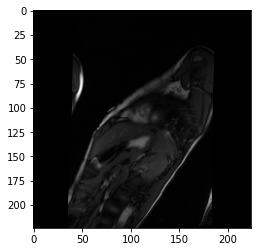

In [49]:
# load the 4D (3D + time) short axis stack - was previously generated by the phaseSelector
sa_stack = phaseSelector.volume
print(sa_stack.shape)

plt.figure()
plt.imshow(sa_stack[8,es_phase,:,:,0], cmap='gray')
plt.show()

In [50]:
# load the slice selection model
MODELPATH = '../models/SliceSelection/slice_selection.hdf5'
model = tf.keras.models.load_model(MODELPATH)

In [51]:
import cv2

slice_selection_preds = []
for i, slice in enumerate(range(sa_stack.shape[0])):
    for phase in range(sa_stack.shape[1]):
        image = sa_stack[slice, phase, :, :, 0]
    
        # resize image
        img = np.expand_dims(image, -1)
        img = img/np.max(img)

        # normalize
        img = img*255
        img = img.astype(np.uint8)
        img = cv2.resize(img, (224,224))

        # convert to rgb
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # make prediction
        pred = model.predict(np.expand_dims(img, 0))
        slice_selection_preds.append([phase, slice, slice_locs[i], np.argmax(pred)])

In [52]:
preds_df = pd.DataFrame(slice_selection_preds, columns=['Filepath', 'Location', 'Image Loc.', 'Prediction'])
slice_locations = np.sort([float(x) for x in preds_df['Location'].unique()])

good_locations = []
report = []
for loc in slice_locations:
    
    loc_df = preds_df[preds_df['Location'] == loc]
    if np.mean(loc_df['Prediction']) > 0.75:
        label = 'Good'
    else:
        label = 'Bad'
    
    image_position = np.round(np.mean(loc_df['Image Loc.']),1)
    if image_position in manual_locs:
        manual_label = 'Good'
        good_locations.append(str(loc))
    else:
        manual_label = 'Bad'
        
    report.append([loc, np.mean(loc_df['Prediction']), np.mean(loc_df['Image Loc.']), label, manual_label])
sa_final_df = pd.DataFrame(report, columns=['Slice.', 'Pred Value', 'Loc', 'Pred Label', 'Manual Label'])
sa_final_df

,Slice.,Pred Value,Loc,Pred Label,Manual Label
0,0.0,0.000000,-69.531288,Bad,Bad
1,1.0,0.000000,-61.350746,Bad,Good
2,2.0,0.100000,-53.170204,Bad,Bad
3,3.0,0.800000,-44.989662,Good,Good
4,4.0,0.633333,-36.809120,Bad,Bad
5,5.0,0.966667,-28.628580,Good,Good
6,6.0,0.533333,-20.448040,Bad,Bad
7,7.0,1.000000,-12.267500,Good,Good
8,8.0,0.000000,-4.086960,Bad,Bad
9,9.0,0.966667,4.093581,Good,Bad


In [53]:
# potential bug - SA stack appears to be ordered wrong by phaseprediction script for CHD4698202,CHD6257105 
# but is ordered correctly by landmark localization script

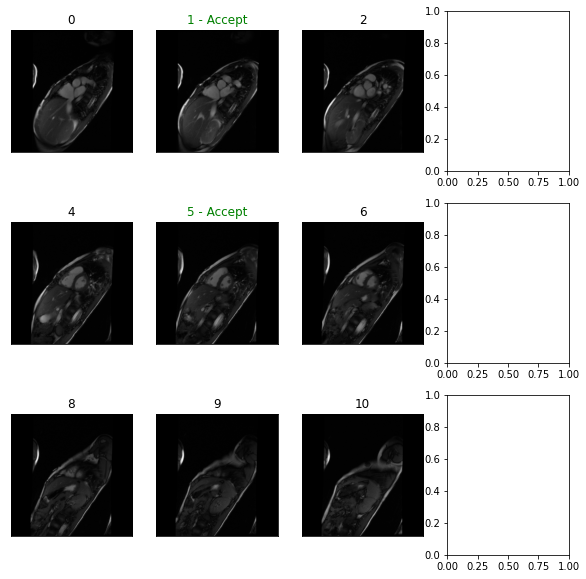

In [53]:
fig, ax = plt.subplots(int(np.ceil(len(slice_locations)/4)), 4, figsize=(10,10))

for i in range(4):
    for j in range(int(np.ceil(len(slice_locations)/4))):
        
        idx = i*4 + j
        if idx > len(slice_locations)-1:
            break
            
        loc = slice_locations[idx]    
        try:
            loc_df = preds_df[preds_df['Location'] == loc]

            ax[i,j].imshow(sa_stack[idx, 15, :, :, 0], cmap='gray')
            if str(loc) in good_locations:
                ax[i,j].set_title('{} - Accept'.format(idx))
                ax[i,j].title.set_color('green')
            else:
                ax[i,j].set_title('{}'.format(idx))
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
        except:
            pass

plt.show()

In [54]:
items = []
for i, loc in enumerate(slice_locations):
    if str(loc) in good_locations:
        items.append(widgets.Checkbox(
            value=True,
            description='Slice {} - {}'.format(i, loc),
            disabled=False,
            indent=False))
    else:
        items.append(widgets.Checkbox(
            value=False,
            description='Slice {} - {}'.format(i, loc),
            disabled=False,
            indent=False))

In [55]:
# make widget with sa slice options
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice 0 - 0.0', indent=False), Checkbox(value=True, descr…

In [87]:
# remove undesired series
good_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        good_locations.append(str(items[i].description.split(' ')[-1]))
        
good_locations

['2.0', '3.0', '4.0', '5.0', '6.0']

### Export 1 - Generate Slice Info File

In [73]:
# generate slice info file for use with python CIM
sliceID = 0
out = []

# check for SA first
for subdir in os.listdir(os.path.join(dst, patient)):
    #if subdir == 'SA':
    if '.' not in subdir:
        stored_locs = []
        for file in os.listdir(os.path.join(dst, patient, subdir)):
            if '.dcm' in file:
                dcm = pydicom.dcmread(os.path.join(dst, patient, subdir, file))
                #if dcm.SliceLocation in good_locations:
                SOPInstanceUID = str(dcm.SOPInstanceUID)
                rows = dcm.Rows
                cols = dcm.Columns
                imagePositionPatient = dcm.ImagePositionPatient
                imageOrientationPatient = dcm.ImageOrientationPatient
                pixelSpacing = dcm.PixelSpacing
                
                if subdir == '4CH':
                    dcm_t = dcm

                if dcm.SliceLocation not in stored_locs:
                    row = [sliceID, file, subdir, dcm.SliceLocation, [rows, cols], imagePositionPatient, imageOrientationPatient, pixelSpacing]
                    out.append(row)
                    stored_locs.append(dcm.SliceLocation)
                    sliceID += 1

# generate dataframe
df = pd.DataFrame(out, columns = ['Slice ID', 'File', 'View', 'Slice Location', 'Size', 'ImagePositionPatient', 'ImageOrientationPatient', 'Pixel Spacing'])

# generate mapping dictionary (short-axis slice to slice id) for future use
sa_df_sorted = df[df['View']=='SA'].sort_values('Slice Location', axis=0)
sa_mapping_dict = {}
for i, row in enumerate(sa_df_sorted.iterrows()):
    index, row = row[0], row[1]
    slice_id = row['Slice ID']
    sa_mapping_dict[slice_id] = i

# display slice info
slice_info_df = df
slice_info_df

,Slice ID,File,View,Slice Location,Size,ImagePositionPatient,ImageOrientationPatient,Pixel Spacing
0,0,MR.2.16.124.113543.6006.99.0663117173855985860...,2CH LT,-29.850693,"[512, 512]","[-144.07, 39.2593, 174.354]","[0.998023, -0.0628469, 0, -0, -0, -1]","[0.5859, 0.5859]"
1,1,MR.2.16.124.113543.6006.99.0663117173855985860...,2CH LT,1.869506,"[512, 512]","[-155.183, 17.1646, 156.354]","[0.991884, -0.127142, 0, -0, -0, -1]","[0.5859, 0.5859]"
2,2,MR.2.16.124.113543.6006.99.1455757969924631742...,3CH,27.240381,"[512, 512]","[-143.597, -10.5023, 145.841]","[0.80017, -0.523485, -0.292729, 0.302912, 0.77...","[0.5469, 0.5469]"
3,3,MR.2.16.124.113543.6006.99.1454898126889720411...,4CH,22.766491,"[512, 512]","[-138.309, -106.816, -0.195984]","[0.926968, -0.0364583, -0.373365, 0.244187, 0....","[0.5859, 0.5859]"
4,4,MR.2.16.124.113543.6006.99.1454898126889720411...,4CH,17.421059,"[512, 512]","[-140.303, -102.76, -5.54142]","[0.926968, -0.0364583, -0.373365, 0.244186, 0....","[0.5859, 0.5859]"
5,5,MR.2.16.124.113543.6006.99.1454898126889720411...,4CH,12.075625,"[512, 512]","[-142.296, -98.7041, -10.8868]","[0.926968, -0.0364583, -0.373365, 0.244186, 0....","[0.5859, 0.5859]"
6,6,MR.2.16.124.113543.6006.99.1454898126889720411...,4CH,6.730193,"[512, 512]","[-144.29, -94.648, -16.2323]","[0.926968, -0.0364583, -0.373365, 0.244187, 0....","[0.5859, 0.5859]"
7,7,MR.2.16.124.113543.6006.99.0665514470822964176...,RVOT,-4.668220,"[512, 512]","[96.914, -81.1737, 182.028]","[-0.586602, 0.809839, -0.00770498, -0.029573, ...","[0.5859, 0.5859]"
8,8,MR.2.16.124.113543.6006.99.0665514470822964176...,RVOT,11.518474,"[512, 512]","[80.7273, -92.8904, 182.87]","[-0.586602, 0.809839, -0.00770498, -0.029573, ...","[0.5859, 0.5859]"
9,9,MR.2.16.124.113543.6006.99.0665514470822964176...,RVOT,-0.621547,"[512, 512]","[92.8673, -84.1028, 182.238]","[-0.586602, 0.809839, -0.00770498, -0.029573, ...","[0.5859, 0.5859]"


In [59]:
# write to slice info file
with open(os.path.join(dst, patient, 'SliceInfo.txt'), 'w') as f:
    for i, row in df.iterrows():
        sliceID = row['Slice ID']
        file = row['File']
        view = row['View']
        imagePositionPatient = row['ImagePositionPatient']
        imageOrientationPatient = row['ImageOrientationPatient']
        pixelSpacing = row['Pixel Spacing']
        
        f.write('{}\t'.format(file))
        f.write('frameID: {}\t'.format(sliceID))
        f.write('timeFrame\t1\t')
        f.write('ImagePositionPatient\t')
        f.write('{}\t{}\t{}\t'.format(imagePositionPatient[0], imagePositionPatient[1], imagePositionPatient[2]))
        f.write('ImageOrientationPatient\t')
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t'.format(imageOrientationPatient[0], imageOrientationPatient[1], imageOrientationPatient[2],
                                            imageOrientationPatient[3], imageOrientationPatient[4], imageOrientationPatient[5]))
        f.write('Pixel Spacing\t')
        f.write('{}\t{}\n'.format(pixelSpacing[0], pixelSpacing[1]))

### Step 4: Landmark Localization

### 4.1 Short-Axis RV Inserts

In [136]:
import landmarklocalization
import importlib
importlib.reload(landmarklocalization)

<module 'landmarklocalization' from 'E:\\CAP\\CAP-FullAutomation\\src\\landmarklocalization.py'>

In [137]:
from landmarklocalization import LandmarkLocalization

In [130]:
# path to the processed dicoms (dicoms that slice info references)
directory = dst + patient
directory

'../data/processed/CHD6257105'

In [91]:
# convert selected slice locations into slice IDs
selected_sa_ids = [x for x in sa_mapping_dict.keys() if str(float(sa_mapping_dict[x])) in good_locations]
selected_sa_ids

[18, 17, 16, 15, 14]

In [96]:
# Initiate a landmark localization module in the short-axis view
ShortAxisLoc = LandmarkLocalization( directory, slice_info_df, 'SA' )

# load model and generate inputs
ShortAxisLoc.load_tensorflow_model()
ShortAxisLoc.num_phases = 40
ShortAxisLoc.test_time_augmentations = False
ShortAxisLoc.number_of_test_augmentations = 10
ShortAxisLoc.generate_mapping_dictionary()
ShortAxisLoc.generate_complete_volume()

# Make landmark predictions for ED phase
ShortAxisLoc.predict_landmarks(phase=0)
ed_output = ShortAxisLoc.output

# Make landmark predictions for ES phase
ShortAxisLoc.predict_landmarks(phase=int(es_phase_float * ShortAxisLoc.num_phases) )
es_output = ShortAxisLoc.output

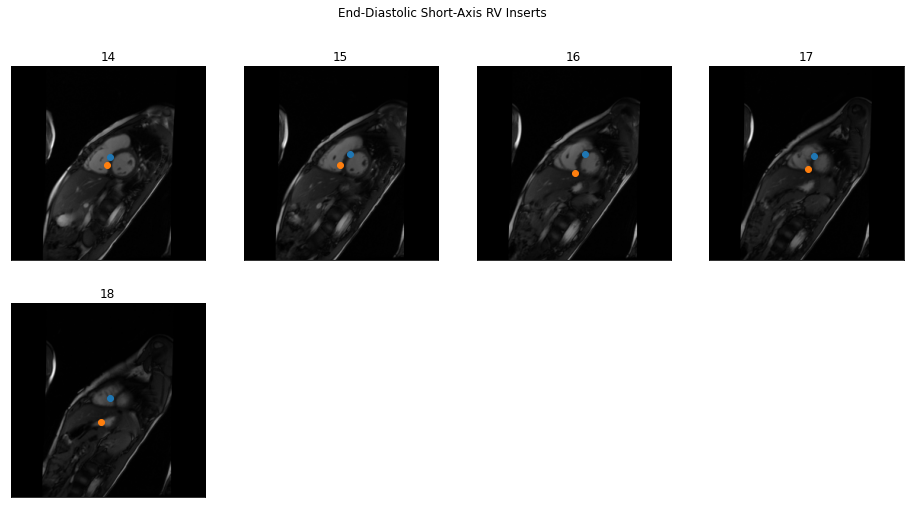

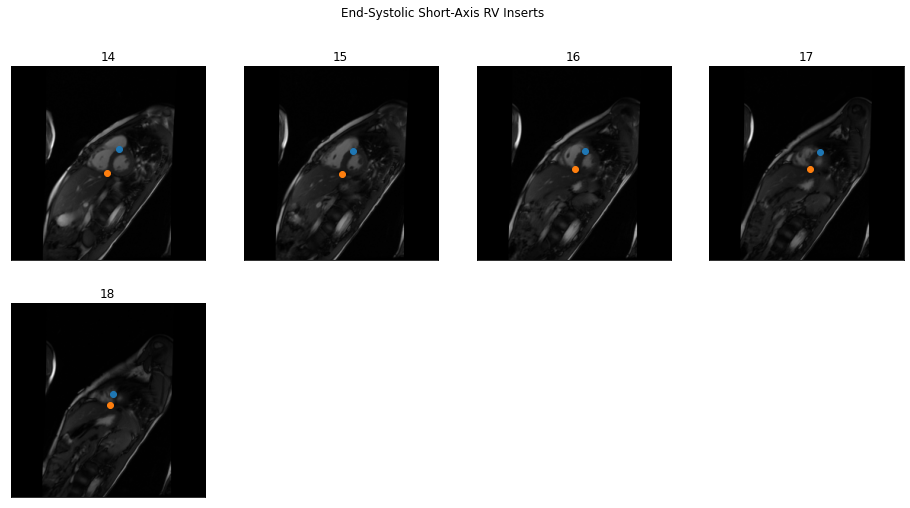

In [97]:
# Store outputs and display inputs/predictions for review
volume = ShortAxisLoc.volume

cols = 4
rows = int(np.ceil(len(selected_sa_ids)/cols))

plt.figure(figsize = (16,4*rows))
count = 1
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    if slice_id in selected_sa_ids:
        p1 = slice[3]
        p2 = slice[4]
        image = volume[slice_id, 0, :, :, 0]

        ax = plt.subplot(rows, cols, count)
        ax.imshow(image, cmap='gray')
        if p1 != None:
            ax.scatter(x=p1[1], y=p1[0])
        if p2 != None:
            ax.scatter(x=p2[1], y=p2[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(slice_id)
        count += 1
plt.suptitle('End-Diastolic Short-Axis RV Inserts')   
plt.show()

plt.figure(figsize = (16,4*rows))
count = 1
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    if slice_id in selected_sa_ids:
        p1 = slice[3]
        p2 = slice[4]
        image = volume[slice_id, int(es_phase_float * ShortAxisLoc.num_phases), :, :, 0]

        ax = plt.subplot(rows, cols, count)
        ax.imshow(image, cmap='gray')
        if p1 != None:
            ax.scatter(x=p1[1], y=p1[0])
        if p2 != None:
            ax.scatter(x=p2[1], y=p2[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(slice_id)
        count += 1
plt.suptitle('End-Systolic Short-Axis RV Inserts')   
plt.show()

In [74]:
sa_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2'])
sa_df = sa_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2']))
sa_df = sa_df[sa_df['Slice ID'].isin(selected_sa_ids)]
#sa_df.loc[9, 'RV2'] = None
#sa_df.loc[9, 'RV1'] = None
sa_df

,Slice ID,View,Time Frame,RV1,RV2
6,12,SA,0,"([103], [120])","([134], [121])"
7,13,SA,0,"([91], [119])","([144], [119])"
9,15,SA,0,"([91], [124])","([145], [122])"
13,19,SA,0,"([87], [126])","([153], [127])"
6,12,SA,11,"([116], [109])","([130], [117])"
7,13,SA,11,"([101], [115])","([142], [119])"
9,15,SA,11,"([102], [113])","([142], [119])"
13,19,SA,11,"([96], [118])","([145], [124])"


### 4.2 Four Chamber Landmark Localization

In [75]:
# Initiate a landmark localization module in the four chamber view
FourChamberLoc = LandmarkLocalization( directory, slice_info_df, '4CH' )

# Load tensorflow model and inputs
FourChamberLoc.load_tensorflow_model()
FourChamberLoc.flip_ud = True
FourChamberLoc.num_phases = 80
FourChamberLoc.generate_mapping_dictionary()
FourChamberLoc.generate_complete_volume()

# Make predictions for ED phase
FourChamberLoc.predict_landmarks(phase=0)
ed_output = FourChamberLoc.output

# Make predictions for ES phase
FourChamberLoc.predict_landmarks(phase=int(es_phase_float * FourChamberLoc.num_phases) )
es_output = FourChamberLoc.output

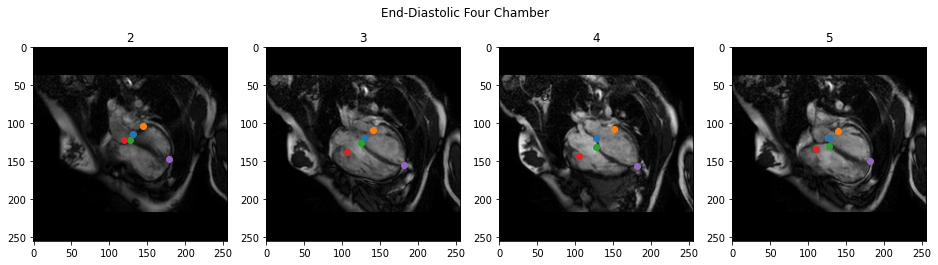

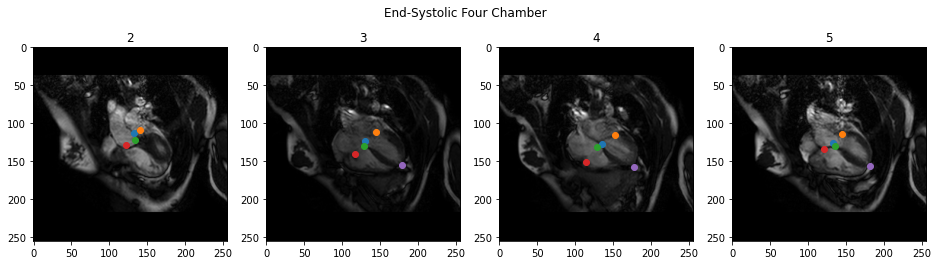

In [76]:
volume = FourChamberLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))
flip_ud = True

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]
    p5 = slice[7]

    image = volume[slice_id, 0, :, :, 0]
    if flip_ud == True:
        image = np.flipud(image)

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1,p2,p3,p4,p5]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.suptitle('End-Diastolic Four Chamber')  
plt.show()

cols = 4
rows = int(np.ceil(len(es_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]
    p5 = slice[7]

    image = volume[slice_id, int(es_phase_float * FourChamberLoc.num_phases), :, :, 0]    
    
    if flip_ud == True:
        image = np.flipud(image)

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1,p2,p3,p4,p5]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.suptitle('End-Systolic Four Chamber')  
plt.show()

In [77]:
options = list(df[df['View'] == '4CH']['Slice ID'])
items = [widgets.Checkbox(
    value=False,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice ID 2', indent=False), Checkbox(value=False, descrip…

In [78]:
selected_4ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_4ch_locations.append(int(items[i].description.split(' ')[-1]))

In [79]:
four_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
four_chamber_df = four_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
)
four_chamber_df = four_chamber_df[four_chamber_df['Slice ID'].isin(selected_4ch_locations)]
four_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,TV1,TV2,LVA
1,3,4CH,0,"([120], [128])","([109], [141])","([127], [125])","([138], [106])","([156], [181])"
2,4,4CH,0,"([120], [128])","([108], [151])","([132], [128])","([144], [105])","([157], [181])"
1,3,4CH,22,"([124], [130])","([112], [144])","([130], [129])","([141], [117])","([156], [179])"
2,4,4CH,22,"([128], [136])","([116], [153])","([132], [129])","([151], [114])","([158], [177])"


### 4.3 Three Chamber Landmark Localization

In [138]:
# Initiate a landmark localization module in the three chamber view
ThreeChamberLoc = LandmarkLocalization( directory, slice_info_df, '3CH' )

# Load tensorflow model and inputs
ThreeChamberLoc.load_tensorflow_model()
ThreeChamberLoc.num_phases = 20
ThreeChamberLoc.test_time_augmentations = True
#ThreeChamberLoc.flip_ud = True
ThreeChamberLoc.generate_mapping_dictionary()
ThreeChamberLoc.generate_complete_volume()

# Make predictions for ED phase
ThreeChamberLoc.predict_landmarks(phase=0)
ed_output = ThreeChamberLoc.output

# Make predictions for ES phase
ThreeChamberLoc.predict_landmarks(phase=int(es_phase_float * ThreeChamberLoc.num_phases))
es_output = ThreeChamberLoc.output

Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  20
Slice number:  12

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated and stored in two places
The number of phases per slice is incorrect, or inconsistent between views
Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  20
Slice number:  13

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated and stored in two places
The number of phases per slice is incorrect, or inconsistent between views
Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  20
Slice number:  14

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated

[(array([122], dtype=int64), array([130], dtype=int64)), (array([122], dtype=int64), array([130], dtype=int64)), (array([132], dtype=int64), array([127], dtype=int64)), (array([128], dtype=int64), array([127], dtype=int64)), (array([124], dtype=int64), array([123], dtype=int64)), (array([127], dtype=int64), array([127], dtype=int64)), (array([124], dtype=int64), array([126], dtype=int64)), (array([124], dtype=int64), array([126], dtype=int64)), (array([124], dtype=int64), array([126], dtype=int64)), (array([124], dtype=int64), array([126], dtype=int64)), (array([127], dtype=int64), array([124], dtype=int64)), (array([126], dtype=int64), array([126], dtype=int64)), (array([124], dtype=int64), array([130], dtype=int64)), (array([124], dtype=int64), array([130], dtype=int64)), (array([125], dtype=int64), array([130], dtype=int64)), (array([120], dtype=int64), array([130], dtype=int64)), (array([120], dtype=int64), array([130], dtype=int64)), (array([124], dtype=int64), array([123], dtype=

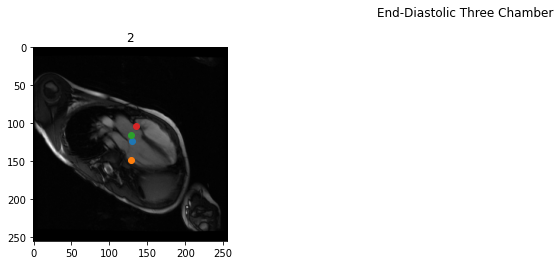

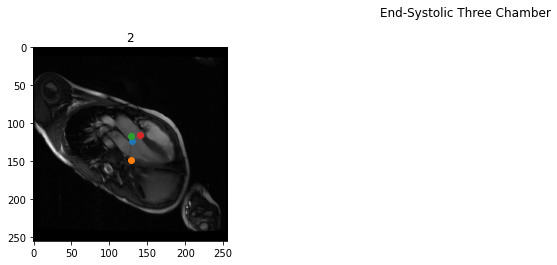

In [139]:
volume = ThreeChamberLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2, p3, p4]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass

plt.suptitle('End-Diastolic Three Chamber')      
plt.show()

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]

    image = volume[slice_id, int(es_phase_float * ThreeChamberLoc.num_phases), :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2, p3, p4]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass

plt.suptitle('End-Systolic Three Chamber')    
plt.show()

In [133]:
options = list(df[df['View'] == '3CH']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))
grid

GridBox(children=(Checkbox(value=True, description='Slice ID 2', indent=False),), layout=Layout(grid_template_…

In [84]:
selected_3ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_3ch_locations.append(int(items[i].description.split(' ')[-1]))

In [85]:
three_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
three_chamber_df = three_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
)

three_chamber_df = three_chamber_df[three_chamber_df['Slice ID'].isin(selected_3ch_locations)]
three_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,AV1,AV2
0,1,3CH,0,"([138], [126])","([157], [115])","([132], [125])","([120], [128])"
0,1,3CH,11,"([133], [104])","([151], [122])","([129], [98])","([120], [130])"


### 4.4 RVOT Landmark Localization

In [86]:
# Initiate a landmark localization module in the RVOT view
RVOTLoc = LandmarkLocalization( directory, slice_info_df, 'RVOT' )

# Load tensorflow model and inputs
RVOTLoc.load_tensorflow_model()
RVOTLoc.num_phases = 40
RVOTLoc.generate_mapping_dictionary()
RVOTLoc.generate_complete_volume()

# Make predictions for ED phase
RVOTLoc.predict_landmarks(phase=0)
ed_output = RVOTLoc.output

# Make predictions for ES phase
RVOTLoc.predict_landmarks(phase=int(es_phase_float * RVOTLoc.num_phases))
es_output = RVOTLoc.output

Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  44
Slice number:  2

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated and stored in two places
The number of phases per slice is incorrect, or inconsistent between views
Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  46
Slice number:  3

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated and stored in two places
The number of phases per slice is incorrect, or inconsistent between views
Unable to copy pixel array to volume. Likely caused by an incorrect phase number, check that your list of dicoms is correct

Information: 
Phase:  77
Slice number:  4

Possible sources of error: 
Duplicate series listed in slice info file (the dicoms are duplicated an

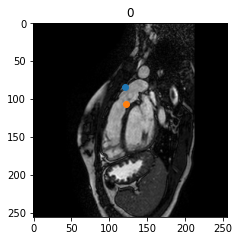

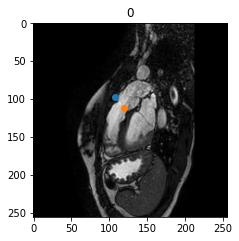

In [87]:
volume = RVOTLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.show()

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]

    image = volume[slice_id, int(es_phase_float * RVOTLoc.num_phases), :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.show()

In [88]:
options = list(slice_info_df[slice_info_df['View'] == 'RVOT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 0', indent=False),), layout=Layout(grid_template_…

In [89]:
selected_rvot_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_rvot_locations.append(int(items[i].description.split(' ')[-1]))

In [90]:
rvot_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2'])
rvot_df = rvot_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2']))
rvot_df = rvot_df[rvot_df['Slice ID'].isin(selected_rvot_locations)]
rvot_df

,Slice ID,View,Time Frame,PV1,PV2
0,0,RVOT,0,"([84], [120])","([107], [122])"
0,0,RVOT,11,"([98], [108])","([112], [119])"


In [91]:
# save all dataframes to csv
landmarks_df = pd.concat([sa_df, four_chamber_df, three_chamber_df, rvot_df])
landmarks_df.to_csv(os.path.join(directory, 'landmark_points.csv'))

#### 4.5 Select 2CH Views

In [92]:
two_chamber_df = slice_info_df[slice_info_df['View'] == '2CH RT']

cols = 4
rows = 1

plt.figure(figsize = (16,4*rows))
two_chamber_df = two_chamber_df.reset_index()
for i, row in two_chamber_df.iterrows():
    
    slice_id = row['Slice ID']
    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    
plt.show()

<Figure size 1152x288 with 0 Axes>

In [93]:
options = list(slice_info_df[slice_info_df['View'] == '2CH RT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(layout=Layout(grid_template_columns='repeat(1, 100px)'))

In [94]:
selected_2ch_rt_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_2ch_rt_locations.append(int(items[i].description.split(' ')[-1]))

out = []
for loc in selected_2ch_rt_locations:
    out.append([loc, '2CH RT', 0])  
    out.append([loc, '2CH RT', es_phase])
    
two_chamber_rt_df = pd.DataFrame(out, columns=['Slice ID', 'View', 'Time Frame'])
two_chamber_rt_df

,Slice ID,View,Time Frame


In [95]:
two_chamber_lt_df = slice_info_df[slice_info_df['View'] == '2CH LT']

cols = 4
rows = 1

plt.figure(figsize = (16,4*rows))
two_chamber_lt_df = two_chamber_lt_df.reset_index()
for i, row in two_chamber_lt_df.iterrows():
    
    slice_id = row['Slice ID']
    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    
plt.show()

<Figure size 1152x288 with 0 Axes>

In [96]:
options = list(slice_info_df[slice_info_df['View'] == '2CH LT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(layout=Layout(grid_template_columns='repeat(1, 100px)'))

In [97]:
selected_2ch_lt_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_2ch_lt_locations.append(int(items[i].description.split(' ')[-1]))

out = []
for loc in selected_2ch_lt_locations:
    out.append([loc, '2CHLT', 0])  
    out.append([loc, '2CHLT', es_phase])
    
two_chamber_lt_df = pd.DataFrame(out, columns=['Slice ID', 'View', 'Time Frame'])
two_chamber_lt_df

,Slice ID,View,Time Frame


### 5. Segmentation

In [113]:
# define I/O parameters for nnUnet segmentation
input_folder = "../data/final/" + patient
output_folder = "../data/segmentations/" + patient

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# default nnUnet parameters
folds = 0
save_npz = False
num_threads_preprocessing = 1
num_threads_nifti_save = 1
lowres_segmentations = None
part_id = False
num_parts = 1
mode = "normal"

For use with the nnUnet pipeline (the model used for segmentation), we need to convert each of the relevant image files to a NIFTI file. The below code used Simple ITK to accomplish this task.

In [99]:
import SimpleITK as sitk

# ensure directory for nii files exists
if not os.path.isdir(os.path.join(input_folder)):
    os.mkdir(os.path.join(input_folder))

# select ED and ES images for each cardiac view, and convert to nifti
view_dataframes = [sa_df, four_chamber_df, three_chamber_df, rvot_df, two_chamber_rt_df, two_chamber_lt_df]
views = ['SA', '4CH', '3CH', 'RVOT', 'RVT', '2CHLT']

for view, df in enumerate(view_dataframes):
    
    # ensure view folder exists
    if not os.path.isdir(os.path.join(input_folder, views[view])):
        os.mkdir(os.path.join(input_folder, views[view]))
        
    for i, row in df.iterrows():
        slice_id = row['Slice ID']
        phase = row['Time Frame']
        
        # extract image array from volume of all slices
        image_array = volume[slice_id, phase, :, :, 0]
        
        # expand dimensions
        image_array = image_array[None, None]
        
        # spacing defined here - could set to pixel spacing instead of 1,1. First value is simply a dummy value since we only
        # have 2D, just needs to be larger than the x and y spacing. 
        spacing = (999,1,1)
        for j, k in enumerate(image_array): # keep for loop here in case additional slices/modalities are needed later
            itk_image = sitk.GetImageFromArray(k)
            itk_image.SetSpacing(list(spacing)[::-1])

            # write nii files to folder for use with nnUnet - only need to save images that need predictions (i.e., ED and ES
            # for selected views/slices. 
            sitk.WriteImage(itk_image, os.path.join(input_folder, views[view],
                                                    '{}_{}_{}'.format(views[view], 
                                                                   slice_id, phase) + "_%04.0d.nii.gz" % j))

In the below code, we will iterate through each of the cardiac views and use the appropriate nnUnet model to make predictions. Models are saved under models/Segmentation/ and are organized by task (i.e., view). 

In [114]:
model_folder = "../models/Segmentation"
tasks = ['Task101_SAX', 'Task108_4CH', 'Task107_3CH', 'Task109_RVOT', 'Task110_RVT', 'Task106_2CH']
views = ['SA', '4CH', '3CH', 'RVOT', 'RVT', '2CHLT']

In [101]:
# reset gpu memory
tf.keras.backend.clear_session()
torch.cuda.empty_cache()

from numba import cuda
cuda.select_device(0)
cuda.close()

In [102]:
# loop through each view
for i, view in enumerate(views):
    
    print('*** Making predictions for {} images ***'.format(view))

    # Define the trained model to use (Specified by the Task)
    model_folder_name = "../models/Segmentation/{}/nnUNetTrainerV2__nnUNetPlansv2.1/".format(tasks[i])

    view_input_folder = os.path.join(input_folder, view)
    view_output_folder = os.path.join(output_folder, view)

    # ensure output folder exists
    if not os.path.isdir(view_output_folder):
        os.mkdir(view_output_folder)
        
    if len(os.listdir(view_input_folder)) > 0:

        # run nnUnet inference directly from folder of 2D nii files
        predict_from_folder(model_folder_name, view_input_folder, view_output_folder, folds, save_npz, num_threads_preprocessing,
                                num_threads_nifti_save, lowres_segmentations, part_id, num_parts, not False, mode=mode)

        print('Done with {}\n'.format(view))

*** Making predictions for SA images ***
This model expects 1 input modalities for each image
Found 8 unique case ids, here are some examples: ['SA_12_11' 'SA_12_11' 'SA_19_11' 'SA_19_11' 'SA_15_0' 'SA_13_0'
 'SA_12_11' 'SA_13_0']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, 0
using the following model files:  ['../models/Segmentation/Task101_SAX/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_final_checkpoint.model']
starting preprocessing generator
starting prediction...
preprocessing ../data/segmentations/CHD8666802/SA/SA_12_0.nii.gz
using preprocessor PreprocessorFor2D
before crop: (1, 1, 256, 256) after crop: (1, 1, 256, 169) spacing: [999.   1.   1.] 

separate z, order in z is 0 order inplane is 3
separate z, order in z is 0 order inplane is 1
before: {'spacing': array([999.,   1.,   1.]), 'spacing_transposed': array([999.,   1.,   1.]), 'data.shape (data is transposed)': (

Done with 4CH

*** Making predictions for 3CH images ***
This model expects 1 input modalities for each image
Found 2 unique case ids, here are some examples: ['3CH_1_0' '3CH_1_0']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, 0
using the following model files:  ['../models/Segmentation/Task107_3CH/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_final_checkpoint.model']
starting preprocessing generator
starting prediction...
preprocessing ../data/segmentations/CHD8666802/3CH/3CH_1_0.nii.gz
using preprocessor PreprocessorFor2D
before crop: (1, 1, 256, 256) after crop: (1, 1, 256, 256) spacing: [999.   1.   1.] 

separate z, order in z is 0 order inplane is 3
separate z, order in z is 0 order inplane is 1
before: {'spacing': array([999.,   1.,   1.]), 'spacing_transposed': array([999.,   1.,   1.]), 'data.shape (data is transposed)': (1, 1, 256, 256)} 
after:  {'spacing': array([999.

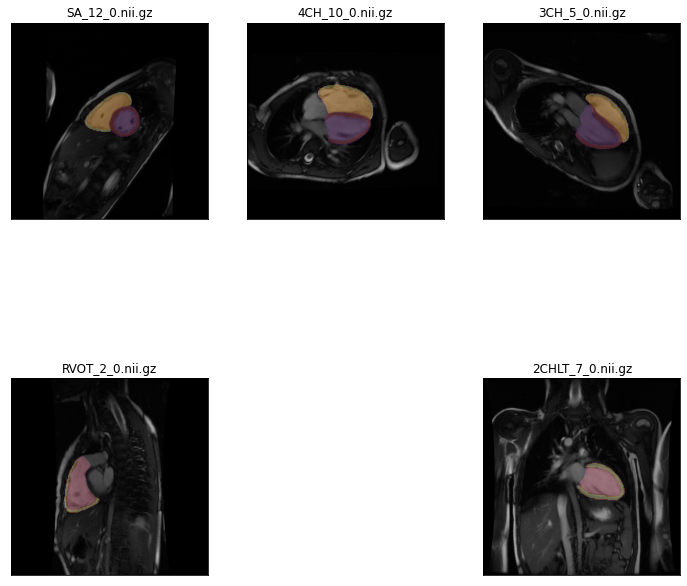

In [115]:
import nibabel as nib
%matplotlib inline

# view some of the segmentations
plt.figure(figsize=(12,12))
for i, view in enumerate(views):
    
    view_output_folder = os.path.join(output_folder, view)
    view_input_folder = os.path.join(input_folder, view)
    segs = os.listdir(view_output_folder)
    segs = [x for x in segs if '.nii.gz' in x]
    
    if len(segs) > 0:
    
        # load first image
        idx = 0

        # change input name to include modality info (nnUnet formatting)
        prefix = segs[idx].split('.')
        input_name = prefix[0] + '_0000.' + prefix[1] + '.' + prefix[2]

        seg = nib.load(os.path.join(view_output_folder, segs[idx]))
        img = nib.load(os.path.join(view_input_folder, input_name))

        ax = plt.subplot(2,3,i+1)
        ax.imshow(np.array(img.dataobj).T[0,:,:], cmap='gray')
        ax.imshow(np.array(seg.dataobj).T[0,:,:], alpha=0.3, cmap='inferno')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(segs[0]) 
    
plt.show()   

In [116]:
np.array(img.dataobj).T[0,:,:].shape

(256, 256)

### 5. Extract Guide Points from Segmentations and Landmarks

Processes the segmentations and landmarks by extracting contours for inclusion in the guide point file. As a part of this process, we perform an inverse transform from image to model coordinates using the affine matrix provided in the DICOM header. 

In [6]:
def parse_string(s):
    try:
        if 'array(' in s:
            p1 = int(s.split('[')[1].split(']')[0])
            p2 = int(s.split('[')[2].split(']')[0])
            return (np.array(p1, dtype=np.int64), np.array(p2, dtype=np.int64))
        else:
            return s
    except:
        return s

In [7]:
# reload landmarks dataframe if necessary
landmarks_df = pd.read_csv(os.path.join('../data/processed', patient, 'landmark_points.csv'),converters={'object':parse_string})
landmarks_df = landmarks_df.drop(columns=['Unnamed: 0']).applymap(parse_string)
landmarks_df                       

,Slice ID,View,Time Frame,Size,RV1,RV2,MV1,MV2,TV1,TV2,LVA,AV1,AV2,PV1,PV2
0,12,SA,0,"[512,512]","(110, 150)","(141, 129)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,SA,0,"[512,512]","(109, 147)","(140, 133)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,SA,0,"[512,512]","(118, 141)","(142, 133)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,SA,0,"[512,512]","(110, 150)","(142, 125)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,SA,10,"[512,512]","(111, 144)","(142, 129)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,SA,10,"[512,512]","(113, 146)","(135, 132)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14,SA,10,"[512,512]","(119, 134)","(134, 131)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,21,SA,10,"[512,512]","(109, 142)","(140, 126)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10,4CH,0,"[512,512]",NaN,NaN,"(128, 97)","(143, 104)","(123, 107)","(93, 101)","(136, 160)",NaN,NaN,NaN,NaN
9,11,4CH,0,"[512,512]",NaN,NaN,"(125, 105)","(147, 106)","(123, 107)","(95, 101)","(137, 166)",NaN,NaN,NaN,NaN


In [29]:
import importlib
import guidepointprocessing
importlib.reload(guidepointprocessing)

<module 'guidepointprocessing' from 'E:\\CAP\\CAP-FullAutomation\\src\\guidepointprocessing.py'>

In [30]:
from guidepointprocessing import GuidePointProcessing

# define I/O parameters for nnUnet segmentation
image_folder = "E:/CAP/CAP-FullAutomation/data/final/" + patient
segment_folder = "E:/CAP/CAP-FullAutomation/data/segmentations/" + patient
output_folder = "E:/CAP/CAP-FullAutomation/data/processed/" + patient

GuidePoints = GuidePointProcessing(patient,
                                  image_folder,
                                  segment_folder,
                                  output_folder,
                                  slice_info_df,
                                  landmarks_df)

In [31]:
GuidePoints.extract_guidepoints(display=False)

Guide point file already exists at E:/CAP/CAP-FullAutomation/data/processed/CHD6257105/GP_ED.txt
Removing file, and regenerating guide points..
Guide point file already exists at E:/CAP/CAP-FullAutomation/data/processed/CHD6257105/GP_ES.txt
Removing file, and regenerating guide points..
14
12


In [32]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
coordinates = []
model_folder = '../data/processed/' + patient
with open(model_folder + '/GP_ED.txt', 'r') as f:
    for i,line in enumerate(f.readlines()):
        if i > 0:
            points = line.split('\t')
            coordinates.append([float(points[0]), float(points[1]), float(points[2]), points[3]])
        
coordinates[-11:]

[[8.26737, 5.15061, 35.37016, 'MITRAL_VALVE'],
 [6.81761, 5.3023, 9.60514, 'MITRAL_VALVE'],
 [6.96192, 7.12103, 37.69355, 'TRICUSPID_VALVE'],
 [12.0565, 2.44192, 70.52807, 'TRICUSPID_VALVE'],
 [-34.07867, 62.60286, 20.77069, 'APEX_POINT'],
 [33.2492, 10.23062, 6.30621, 'MITRAL_VALVE'],
 [38.80246, 36.07599, 23.8468, 'MITRAL_VALVE'],
 [7.23915, 7.41094, 47.05937, 'AORTA_VALVE'],
 [12.0565, 2.44192, 70.52807, 'AORTA_VALVE'],
 [24.78724, 7.66746, 7.51705, 'PULMONARY_VALVE'],
 [33.2437, -8.11034, -7.60896, 'PULMONARY_VALVE']]

In [33]:
len_colors = len(np.unique(np.array(coordinates)[:,3]))
from matplotlib import cm
new_map = plt.cm.get_cmap('hsv', len_colors)

map = set(np.array(coordinates)[:,3])
map_dict = {'AORTA_VALVE': 'r',
 'MITRAL_VALVE': 'b',
 'RV_INSERT': 'g',
 'APEX_POINT': 'y',
 'SAX_RV_FREEWALL': '#F2CA19',
 'LAX_LV_EPICARDIAL': '#0057E9',
 'TRICUSPID_VALVE': 'k',
 'LAX_RV_SEPTUM': '#E11845',
 'SAX_RV_SEPTUM': '#E11845',
 'LAX_RV_EPICARDIAL': '#0057E9',
 'LAX_RV_FREEWALL': '#F2CA19',
 'PULMONARY_VALVE': 'purple',
 'SAX_LV_ENDOCARDIAL': '#87E911',
 'SAX_LV_EPICARDIAL': '#0057E9',
 'SAX_RV_EPICARDIAL': '#0057E9',
 'LAX_LV_ENDOCARDIAL': '#87E911'}

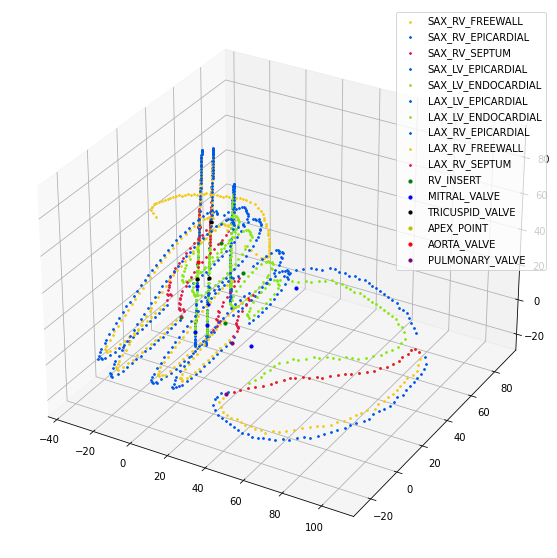

In [34]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

labels = []
for p1 in coordinates:
    lab = p1[3]
    if 'LAX' in lab or 'SAX' in lab:
        s = 3
    else:
        s = 10
        
    if lab in labels:
        ax.scatter3D(p1[0], p1[1], p1[2], color=map_dict[lab], s=s)
    else:
        labels.append(lab)
        ax.scatter3D(p1[0], p1[1], p1[2], color=map_dict[lab], label=p1[3], s=s)
plt.legend()
plt.show()

In [226]:
orientList = []
for file in os.listdir(os.path.join(dst, patient, 'RVOT')):
    if '.dcm' in file:
        dcm = pydicom.dcmread(os.path.join(dst, patient, 'RVOT', file))
        orient = dcm.ImageOrientationPatient
        print(dcm.Rows, dcm.Columns)
        orientList.append(orient)

512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512


In [57]:
# 4CH
np.unique(orientList)

array([-1.       , -0.127142 , -0.0628469, -0.       ,  0.991884 ,
        0.998023 ])

In [56]:
# SA
np.unique(orientList)

array([-1.       , -0.127142 , -0.0628469, -0.       ,  0.991884 ,
        0.998023 ])

In [27]:
# 3CH
np.unique(orientList)

array([-0.556075, -0.523485, -0.292729,  0.302912,  0.773967,  0.80017 ])

In [29]:
# RVOT
np.unique(orientList)

array([-0.999084  , -0.586602  , -0.0309266 , -0.029573  , -0.00770498,
        0.809839  ])

In [33]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.02529336122945478404
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.03293010529925929080
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER', 'JP2K LOSSY 6:1']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113543.6006.99.02529336122945478404
(0008, 0020) Study Date          

In [58]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.8670841109149483621
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.03293010529925929080
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER', 'JP2K LOSSY 6:1']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113543.6006.99.8670841109149483621
(0008, 0020) Study Date            

In [37]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.09072892575898165127
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.03293010529925929080
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER', 'JP2K LOSSY 6:1']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113543.6006.99.09072892575898165127
(0008, 0020) Study Date          

In [40]:
# 2CH
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.8670841109149483621
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.03293010529925929080
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER', 'JP2K LOSSY 6:1']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113543.6006.99.8670841109149483621
(0008, 0020) Study Date            